# pset 03: the adventure of the undead genes


In [1]:
#importing allowed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# reading Moriarty's data into a dataframe
mo_supp = pd.read_table('Moriarty_SuppTable1.tsv', comment='#')
mo_supp.head()

gene   class     0m     3m     6m     9m    12m    15m    18m    21m  \
0  fcnZ   early   5.00   3.00   0.00   0.00   0.00   0.00   0.00   0.00   
1  mnsN   early  12.00   5.00   1.00   0.00   0.00   0.00   0.00   0.00   
2  eqoN  middle  65.01  68.97  60.96  40.95  22.95  16.98   8.98  10.98   
3  gupU   early  65.01  31.98  35.97  25.97  22.95   8.99  12.97   6.99   
4  wccP   early  68.01  50.98  38.97  21.97  18.96   7.99   3.99   5.99   

     24m  27m  30m  
0   0.00  0.0  0.0  
1   0.00  0.0  0.0  
2  10.99  3.0  1.0  
3   3.00  2.0  1.0  
4   0.00  1.0  2.0

In [3]:
# reading Adler's data into a dataframe
ad_supp = pd.read_table('Adler_SuppTable2.tsv', comment='#')
ad_supp.head()

gene  synthesis_rate  halflife
0  lsuW            0.27      1.85
1  ilaK            0.01      0.47
2  rmwC            0.58     14.76
3  dcwO            0.28      3.12
4  ajqX            0.31      2.58

## **task 1a** - fixing corrupted gene names caused by pandas import

To look for any gene name corruption caused by pandas import, I compared the gene names that appear in the original .tsv file to the gene names that appear in the new pandas DataFrame. I did that by opening the original file with basic Python's `open`, extracting the gene names, and checking whether they match the pandas DataFrame.

In [4]:
# defining the file paths for both data files
file_paths = ['Moriarty_SuppTable1.tsv', 'Adler_SuppTable2.tsv']

for path in file_paths: 
    # initializing an empty list to store gene names from the original file
    original_genes = []

    # opening the file and iterating through the lines
    with open(path, 'r') as file:
        # skipping the first 3 comment lines to reach the header
        for line in range(3):
            next(file)
            
        # reading the header and splitting by tab to find the 'gene' column
        header = file.readline().strip().split('\t')
        
        # identifying the index of the 'gene' column
        gene_idx = header.index('gene')
        
        # iterating over the rest of the file to extract gene names
        for line in file:
            if line.strip():  # ensures the line is not empty
                values = line.strip().split('\t')
                original_genes.append(values[gene_idx])

    # extracting the genes column from the pandas DataFrame
    df = pd.read_table(path, comment='#')
    pandas_genes = df['gene'].tolist()

    # listing genes only in the original file and genes only in the pandas import)
    only_original = [gene for gene in original_genes if gene not in pandas_genes]
    only_pandas = [gene for gene in pandas_genes if gene not in original_genes]
    
    print(f'In file "{path}":')
    if only_original:
        print(f'The following gene(s) were found in the original data but are missing after pandas import: {only_original}')
    if only_pandas:
        print(f'The following gene(s) were found only after pandas import: {only_pandas}')
    else:
        print('All gene names in the original file are present after pandas import.')
    
    print('\n')

In file "Moriarty_SuppTable1.tsv":
The following gene(s) were found in the original data but are missing after pandas import: ['nan']
The following gene(s) were found only after pandas import: [nan]


In file "Adler_SuppTable2.tsv":
The following gene(s) were found in the original data but are missing after pandas import: ['nan']
The following gene(s) were found only after pandas import: [nan]




In both datasets, I found a gene called "nan" only in the original files, while in the pandas DataFrames it appears as `nan`. I know that `nan` (or `NaN`) represents null values in pandas DataFrames, so I suspected that pandas had corrupted the gene name "nan" by treating it as a null value. To check this, I ran the following code:

In [5]:
# defining the file paths for both data files
file_paths = ['Moriarty_SuppTable1.tsv', 'Adler_SuppTable2.tsv']

for path in file_paths: 
    # reading the file into a pandas dataframe
    df = pd.read_table(path, comment='#')
    
    if df['gene'].isnull().any() == True: 
        na_rows = df[df['gene'].isnull()] # identifys rows where the 'gene' column contains null values
        print(f'In file "{path}": The following row(s) contain a null value in "gene" column - \n')
        print(na_rows)
        print('\n')
    else:
        print(f'There are no null values in "gene" column in file "{path}"')

In file "Moriarty_SuppTable1.tsv": The following row(s) contain a null value in "gene" column - 

     gene  class    0m   3m   6m   9m  12m  15m  18m  21m  24m  27m  30m
2532  NaN  early  12.0  3.0  3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In file "Adler_SuppTable2.tsv": The following row(s) contain a null value in "gene" column - 

     gene  synthesis_rate  halflife
4211  NaN            0.07      1.24




This confirmed that pandas had corrupted the gene name "nan" by treating it as `NaN` in both files. To fix this issue and re-import the files properly, I added `keep_default_na=False`, which prevents pandas from reading "nan" as a null value:

In [6]:
mo_supp = pd.read_table('Moriarty_SuppTable1.tsv', comment='#', keep_default_na = False)
ad_supp = pd.read_table('Adler_SuppTable2.tsv', comment='#', keep_default_na = False)

# checking if there are any null values in the 'gene' column and printing True/False
print(mo_supp['gene'].isnull().any())
print(ad_supp['gene'].isnull().any())

False
False


## **task 1b** - fixing corrupted gene names caused by Excel

Moriarty exported his table from Excel, which is known to **corrupt gene names through date or floating-point format conversions**. Since format outliers tend to sort to the edges, I started by sorting Moriarty's data by gene name to find possible outliers.

In [7]:
# sortting to find outliers in Moriarty's gene names - ascending
mo_supp.sort_values(by='gene').head(10)

gene   class       0m       3m       6m       9m      12m      15m  \
578   1-Dec  middle   103.02    92.96   128.91   120.86   135.70   167.83   
1586  1-Mar   early    65.01    14.99     5.00     7.99     1.00     1.00   
3115  1-Oct   early    17.00    13.99     5.00     3.00     2.99     2.00   
428   1-Sep   early   429.08   244.88   126.91    67.92    34.92    17.98   
689   2-Mar   early   146.03   101.95    88.93    62.93    33.92    34.96   
3439  2-Oct   early    22.00    10.00    12.99     8.99     7.98     2.00   
2308  2-Sep    late  1127.20  1681.19  2088.47  2530.09  3051.19  3420.50   
2750   aacU  middle   180.03   225.89   221.84   224.74   232.48   208.79   
3713   aalG   early    72.01    22.99     9.99     2.00     2.00     0.00   
3476   aavD  middle     8.00     9.00     5.00     3.00     7.98    11.99   

          18m      21m      24m      27m      30m  
578    156.65   147.76   163.90   166.88   148.08  
1586     0.00     0.00     0.00     0.00     0.00  
3115     1.00     0.00     1.00     1.00     1.00  
428      6.98     1.00     2.00     1.00     1.00  
689     40.91    24.96    17.99    15.99     3.00  
3439     2.99     3.00     2.00     4.00     4.00  
2308  3934.13  4481.83  4926.05  5380.05  5647.17  
2750   197.55   165.73   153.91   140.90   145.08  
3713     0.00     0.00     0.00     0.00     0.00  
3476    11.97    11.98     6.00     6.00     7.00

In [8]:
# sortting to find outliers in Moriarty's gene names - descending
mo_supp.sort_values(by='gene', ascending=False).head(10)

gene   class      0m      3m      6m       9m      12m      15m  \
2438  zzyT   early  156.03  117.94   95.93    94.89    72.84    55.94   
2144  zzxG   early  141.03   33.98   15.99     2.00     1.00     0.00   
1305  zzuJ   early   31.01    2.00    0.00     0.00     0.00     0.00   
872   zztB   early  187.03  126.94   83.94    43.95    20.95    15.98   
3733  zzmY   early    2.00    0.00    0.00     0.00     0.00     0.00   
2768  zziF  middle    8.00    6.00    5.00     8.99     5.99     4.99   
3055  zzeJ   early  183.03   22.99    5.00     0.00     0.00     0.00   
2678  zypC   early   25.00   17.99    3.00     4.00     4.99     2.00   
4118  zykS    late  575.10  755.64  910.33  1125.70  1338.01  1575.39   
1327  zyiT   early   28.01   23.99   12.99     4.00     3.99     1.00   

          18m      21m      24m      27m      30m  
2438    32.93    31.95    14.99    14.99    11.01  
2144     0.00     0.00     0.00     0.00     0.00  
1305     0.00     0.00     0.00     0.00     0.00  
872      8.98     6.99     3.00     0.00     0.00  
3733     0.00     0.00     0.00     0.00     0.00  
2768     2.00     3.00     0.00     0.00     5.00  
3055     0.00     0.00     0.00     0.00     0.00  
2678     2.00     0.00     0.00     0.00     0.00  
4118  1795.95  2022.76  2185.69  2365.26  2593.45  
1327     1.00     1.00     0.00     0.00     0.00

I immediately spotted 7 format outliers that appear in a **classic Excel date format**. To investigate more methodically and ensure these are the only outliers, I looped through all the gene names in Moriarty's data and Adler's data and extracted lists of genes that appear only in one and not the other.

In [9]:
# extracting the gene name column from both DataFrames
mo_genes = mo_supp['gene'].tolist()
ad_genes = ad_supp['gene'].tolist()

# listing genes only in mo_supp & genes only in ad_supp
only_mo = [gene for gene in mo_genes if gene not in ad_genes]
only_ad = [gene for gene in ad_genes if gene not in mo_genes]

if only_mo:
    print(f"The following gene(s) were found in Moriarty's data but are missing in Adler's data: {only_mo}\n")
if only_ad:
    print(f"The following gene(s) were found in Adler's data but are missing in Moriarty's data: {only_ad}\n")
else:
    print("All gene names in Moriarty's data match Adler's data.")

The following gene(s) were found in Moriarty's data but are missing in Adler's data: ['1-Sep', '1-Dec', '2-Mar', '1-Mar', '2-Sep', '1-Oct', '2-Oct']

The following gene(s) were found in Adler's data but are missing in Moriarty's data: ['oct1', 'mar1', 'oct2', 'sep2', 'mar2', 'dec1', 'sep1']



This confirmed what had happened — **Excel converted these seven gene names**: 'oct1', 'mar1', 'oct2', 'sep2', 'mar2', 'dec1', 'sep1' **into date format**: '1-Sep', '1-Dec', '2-Mar', '1-Mar', '2-Sep', '1-Oct', '2-Oct'. To fix this issue, I used pandas methods to apply a format transformation to the gene names so they would match the ones in Adler's data:

In [10]:
# applying transformation directly to the 'gene' column in mo_supp
mo_supp['gene'] = mo_supp['gene'].apply(
    lambda gene: f"{gene.split('-')[1].lower()}{gene.split('-')[0]}" if gene in only_mo else gene)

Running the same code block from before, comparing the gene names between the two DataFrames, confirmed that they now match:

In [11]:
# extracting the gene name column from both DataFrames
mo_genes = mo_supp['gene'].tolist()
ad_genes = ad_supp['gene'].tolist()

# listing genes only in mo_supp & genes only in ad_supp
only_mo = [gene for gene in mo_genes if gene not in ad_genes]
only_ad = [gene for gene in ad_genes if gene not in mo_genes]

if only_mo:
    print(f"The following gene(s) were found in Moriarty's data but are missing in Adler's data: {only_mo}\n")
if only_ad:
    print(f"The following gene(s) were found in Adler's data but are missing in Moriarty's data: {only_ad}\n")
else:
    print("All gene names in Moriarty's data match Adler's data.")

All gene names in Moriarty's data match Adler's data.


## **task 2** - tidying Moriarty's data

In [12]:
# melting the data to convert from wide to long format
long_mo_supp = pd.melt(mo_supp, id_vars=['gene', 'class'], var_name='time', value_name='tpm')

# converting the 'time' column to integers instead of strings
long_mo_supp['time'] = long_mo_supp['time'].str.replace('m', '').astype(int)

# setting the gene names as the index
long_mo_supp.set_index('gene', inplace=True)

long_mo_supp.head()

class  time    tpm
gene                     
fcnZ   early     0   5.00
mnsN   early     0  12.00
eqoN  middle     0  65.01
gupU   early     0  65.01
wccP   early     0  68.01

In [13]:
# setting the gene names as the index also in ad_supp
ad_supp.set_index('gene', inplace=True)
ad_supp.head()

synthesis_rate  halflife
gene                          
lsuW            0.27      1.85
ilaK            0.01      0.47
rmwC            0.58     14.76
dcwO            0.28      3.12
ajqX            0.31      2.58

## **task 3** - preliminary exploration of the data

In [14]:
# extracting the five genes with the highest mRNA synthesis rate from ad_supp
top5_synthesis_rate = ad_supp.nlargest(5, 'synthesis_rate')
top5_synthesis_rate

synthesis_rate  halflife
gene                          
uzdZ           15.96      2.45
mkqZ           15.39      8.91
pfhT           14.67      1.48
coxU           13.28      1.74
wduX           12.02      2.65

In [15]:
# extracting the five genes with the longest mRNA halflife from ad_supp
top5_halflife = ad_supp.nlargest(5, 'halflife')
top5_halflife

synthesis_rate  halflife
gene                          
qonD            0.16    114.98
cxyH            0.15     63.57
znkB            0.07     57.79
qyfB            0.14     52.48
qunV            0.33     42.06

To calculate the expression ratio at t=30 vs. t=0, I found it easier to work with the wide format of Moriarty's data and add a new column named `30_0_ratio`. I felt that the expression ratio compared to t=0 would only be meaningful for genes that had at least some expression level at t=0, so for genes where t=0 was 0, I filled a null value in this column.

In [16]:
# calculating the expression ratio at t=30 vs. t=0 (only where t=0 expression is greater than zero)
mo_supp['30_0_ratio'] = mo_supp['30m'].div(mo_supp['0m']).where(mo_supp['0m'] > 0, np.nan)

# extracting the five genes with the highest expression ratio at t=30 vs. t=0
top5_30_0_ratio = mo_supp.nlargest(5, '30_0_ratio')
top5_30_0_ratio

gene class       0m       3m       6m       9m      12m       15m  \
2604  qonD  late  3144.56  4446.87  6107.52  7636.21  9492.80  11710.03   
1158  znkB  late   606.11   946.55  1290.05  1547.22  1869.82   2325.62   
4006  cxyH  late  1609.29  2367.86  3135.70  3913.50  4912.03   5933.94   
2694  qyfB  late  1263.23  1794.14  2290.32  2843.73  3649.85   4227.68   
1278  nwoU  late    37.01    35.98    60.96    80.91   102.77    107.89   

           18m       21m       24m       27m       30m  30_0_ratio  
2604  14004.43  16428.71  19183.53  22259.64  25158.11    8.000518  
1158   2763.77   2982.23   3506.90   3953.09   4609.59    7.605204  
4006   6774.73   7895.37   9271.46  10397.36  11722.58    7.284318  
2694   4881.00   5684.90   6371.19   7297.64   8352.69    6.612169  
1278    120.73    124.80    169.90    196.86    243.14    6.569576

Interestingly, the five **genes with the highest expression ratio at t=30 vs. t=0 all belong to Moriarty's "late" gene class**. Additionally, **four of the genes with the longest mRNA halflife overlap with those that have the highest expression ratio at t=30 vs. t=0**. This would be useful in explaining Moriarty's results, and I continued exploring these relationships later in the pset (task 5).

## **task 4** - merging the data into a master table

When merging data frames to create a master table for downstream analysis, I decided to filter out all the genes with TPM = 0 at t=0. To do this, I filtered out all the rows in the master table that had a `NaN` value in any of the columns, because `NaN` values were only introduced in response to TPM = 0 at t=0 (when creating the 30/0 ratio column).

In [17]:
master_table_wide = pd.merge(mo_supp, ad_supp, on='gene')
master_table_wide = master_table_wide.dropna()
master_table_wide.head()

gene   class     0m     3m     6m     9m    12m    15m    18m    21m  \
0  fcnZ   early   5.00   3.00   0.00   0.00   0.00   0.00   0.00   0.00   
1  mnsN   early  12.00   5.00   1.00   0.00   0.00   0.00   0.00   0.00   
2  eqoN  middle  65.01  68.97  60.96  40.95  22.95  16.98   8.98  10.98   
3  gupU   early  65.01  31.98  35.97  25.97  22.95   8.99  12.97   6.99   
4  wccP   early  68.01  50.98  38.97  21.97  18.96   7.99   3.99   5.99   

     24m  27m  30m  30_0_ratio  synthesis_rate  halflife  
0   0.00  0.0  0.0    0.000000            0.03      1.28  
1   0.00  0.0  0.0    0.000000            0.04      1.71  
2  10.99  3.0  1.0    0.015382            0.12      3.73  
3   3.00  2.0  1.0    0.015382            0.08      3.71  
4   0.00  1.0  2.0    0.029407            0.13      3.02

Having a wide master table, I also wanted to create a "tidy" version in long format, in case I needed it later.

In [18]:
# melting the master_table_wide to convert from wide to long format (for the expression ratios)
master_table_long = pd.melt(master_table_wide, id_vars=['gene', 'class', '30_0_ratio', 'synthesis_rate', 'halflife'],
        var_name='time', value_name='tpm')

# reordering the columns in master_table_long
master_table_long = master_table_long[['gene', 'class', 'time', 'tpm', 'synthesis_rate', 'halflife', '30_0_ratio']]

# setting the gene names as the index
master_table_long.set_index('gene', inplace=True)

master_table_long.head()

class time    tpm  synthesis_rate  halflife  30_0_ratio
gene                                                          
fcnZ   early   0m   5.00            0.03      1.28    0.000000
mnsN   early   0m  12.00            0.04      1.71    0.000000
eqoN  middle   0m  65.01            0.12      3.73    0.015382
gupU   early   0m  65.01            0.08      3.71    0.015382
wccP   early   0m  68.01            0.13      3.02    0.029407

## **task 5** - further exploration of the data & plotting

Trying to provide an alternative explanation for Moriarity's "thanatotranscriptome" and to explain why some of the genes in his RNA-seq data appear to be upregulated, I started by summarizing what I knew:
1. Moriarity used rifampin to inhibit RNA polymerase at t=0, causing global transcription inhibition and cell death. 
2. Moriarity used transcripts per million (TPM) to quantify expression. 
3. Moriarity classified each gene according to its change in TPM values over time.

I wanted to further explore the connection between class type, halflife, synthesis rate, and 30/0 TPM ratio values. To do this, I created a table that summarized the median, std, and total count for each class. I chose to use the median rather than the mean because the variation in the data is relatively high (as can be seen by the std values), and the median is less sensitive to extreme values. 

I then plotted the relationship between class and each parameter using a strip plot layered on top of a box plot, showing the median as part of the box plot while also displaying the actual distribution of data point on top of it.

In [19]:
# selecting relevant columns from the master table
df = master_table_wide[['class', 'synthesis_rate', 'halflife', '30_0_ratio']] 

# applying multiple aggregation functions (mean, median, sum, count) to numeric columns, grouped by class
grouped_summary = df.groupby('class').agg(['median', 'std', 'count'])

grouped_summary

synthesis_rate                 halflife                  30_0_ratio  \
               median       std count   median        std count     median   
class                                                                        
early            0.10  0.873374  2766     2.45   1.357542  2766   0.000000   
late             0.10  0.954657   157    18.68  11.579971   157   3.307319   
middle           0.06  0.670829  1408     6.87   3.289471  1408   0.500329   

                        
             std count  
class                   
early   0.065099  2766  
late    1.324309   157  
middle  0.728366  1408

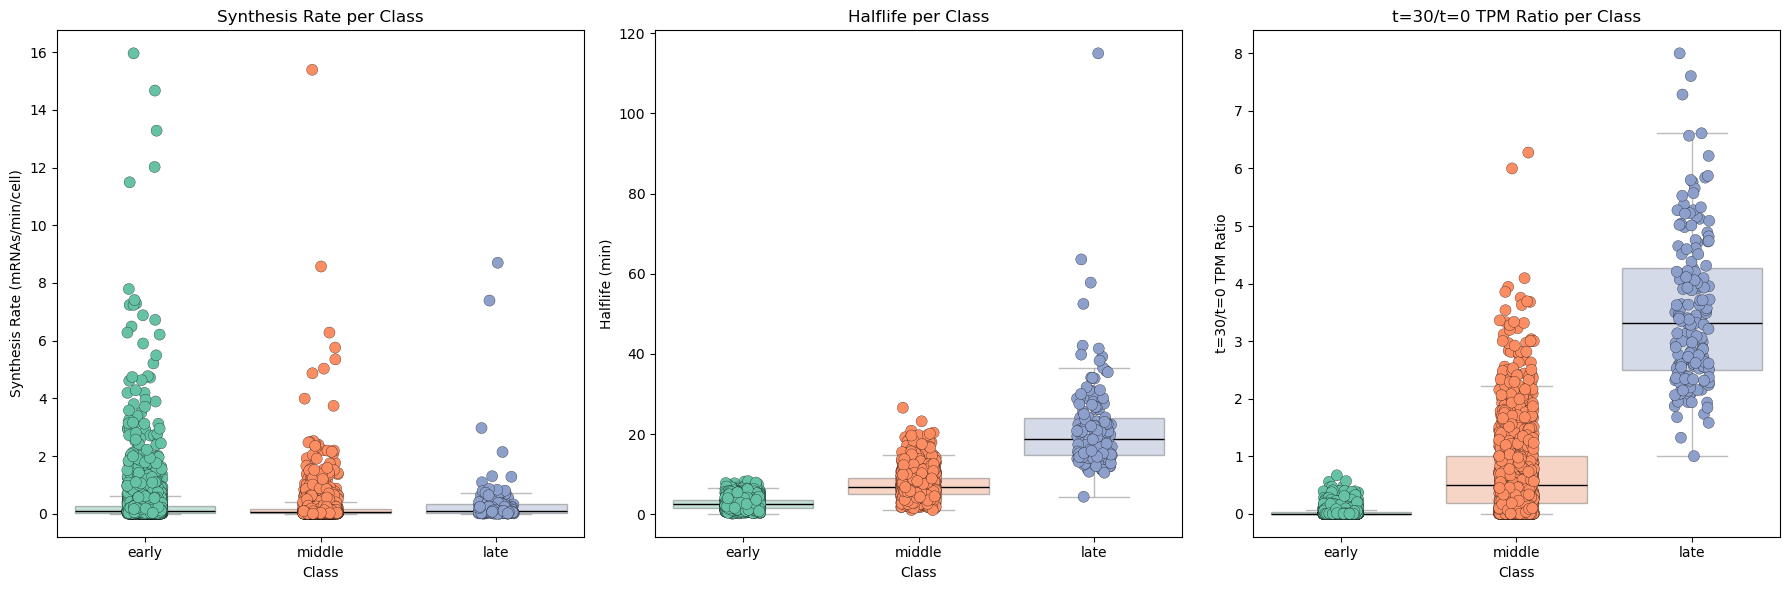

In [20]:
# creating the figure with three subplots (synthesis rate, halflife, and 30over0 expression ratio)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# first subplot: box plot and strip plot for synthesis rate per class
sns.boxplot(data=master_table_wide, x='class', y='synthesis_rate', hue='class', palette='Set2', ax=ax1, 
            boxprops=dict(alpha=0.4), whiskerprops=dict(alpha=0.4), capprops=dict(alpha=0.4), 
            medianprops=dict(color='black'), showcaps=True, fliersize=0)

sns.stripplot(data=master_table_wide, x='class', y='synthesis_rate', hue='class', palette='Set2', ax=ax1, 
              size=8, jitter=True, alpha=1, edgecolor='black', linewidth=0.2, legend=False)

# setting labels and title for the first plot
ax1.set_title('Synthesis Rate per Class')
ax1.set_xlabel('Class')
ax1.set_ylabel('Synthesis Rate (mRNAs/min/cell)')

# second subplot: box plot and strip plot for halflife per class
sns.boxplot(data=master_table_wide, x='class', y='halflife', hue='class', palette='Set2', ax=ax2, 
            boxprops=dict(alpha=0.4), whiskerprops=dict(alpha=0.4), capprops=dict(alpha=0.4), 
            medianprops=dict(color='black'), showcaps=True, fliersize=0)

# using hue='class' and setting legend=False for the strip plot to match the color palette
sns.stripplot(data=master_table_wide, x='class', y='halflife', hue='class', palette='Set2', ax=ax2, 
              size=8, jitter=True, alpha=1, edgecolor='black', linewidth=0.2, legend=False)

# setting labels and title for the second plot
ax2.set_title('Halflife per Class')
ax2.set_xlabel('Class')
ax2.set_ylabel('Halflife (min)')

# third subplot: box plot and strip plot for 30over0 expression ratio per class
sns.boxplot(data=master_table_wide, x='class', y='30_0_ratio', hue='class', palette='Set2', ax=ax3, 
            boxprops=dict(alpha=0.4), whiskerprops=dict(alpha=0.4), capprops=dict(alpha=0.4), 
            medianprops=dict(color='black'), showcaps=True, fliersize=0)

sns.stripplot(data=master_table_wide, x='class', y='30_0_ratio', hue='class', palette='Set2', ax=ax3, 
              size=8, jitter=True, alpha=1, edgecolor='black', linewidth=0.2, legend=False)

# setting labels and title for the third plot
ax3.set_title('t=30/t=0 TPM Ratio per Class')
ax3.set_xlabel('Class')
ax3.set_ylabel('t=30/t=0 TPM Ratio')

# adjusting layout for better spacing
plt.tight_layout()

# displaying the plot
plt.show()

From this analysis, I understood that the **differences between classes are most apparent in halflife time and the ratio of TPM at t=30 over TPM at t=0, but not in the synthesis rate**.

In the context of Moriarity's experiment, the synthesis rate is not relevant after t=0 due to the inhibition of RNA polymerase, so it makes sense that the synthesis rate would not affect gene behavior or data classification. It also makes sense that the 30/0 TPM ratio would differ between classes, as Moriarity classified the genes based on their increase or decrease in TPM values over time - aarly genes had TPMs that decreased rapidly over time, middle genes showed some decrease at later time points, and late genes exhibited an increase throughout. This pattern is supported by the 30/0 ratio plot.

The connection between class and halflife time was especially interesting — early genes had the shortest halflives, while late genes had the longest, with middle genes having halflife times in between. To explore this further, **I plotted the relationship between half-life time and the 30/0 ratio in relation to class**:

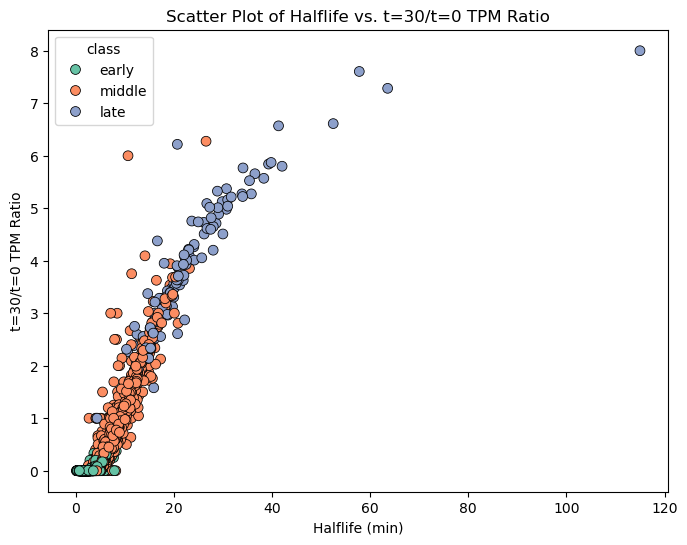

In [21]:
# creating the scatter plot with half-life on x-axis and 30_0_ratio on y-axis
plt.figure(figsize=(8, 6))
sns.scatterplot(data=master_table_wide, x='halflife', y='30_0_ratio', hue='class', palette='Set2', s=50, edgecolor='black')

# setting labels and title
plt.xlabel('Halflife (min)')
plt.ylabel('t=30/t=0 TPM Ratio')
plt.title('Scatter Plot of Halflife vs. t=30/t=0 TPM Ratio')

# displaying the plot
plt.show()

This plot showed a **clear correlation between halflife time and 30/0 TPM ratio across gene classes** — the longer a gene's half-life time, the higher its 30/0 TPM ratio, and the more likely it is to belong to a later class.

## **main conclusion**

All the analyses up to this point show that **mRNA halflife time has an effect on Moriarity's interpretation of the data**. Knowing that gene classification is connected to halflife time helps explain Moriarity's results:

Moriarity used TPM to measure expression levels in his experiment. **TPM is a relative measure**, reporting the **proportion of reads that map to a transcript relative to all other mapped reads in the sample**. Since no new mRNAs can be synthesized after RNA polymerase inhibition, and assuming no RNA-dependent RNA replication, the existing mRNA in the cell (t=0) **must be degrading over time**.  However, **not all mRNAs degrade at the same rate** — the slower an mRNA's decay rate is, the longer it takes for it to degrade. Halflife time is indicative of the mRNA decay rate: the longer the halflife, the slower the decay (decay rate = ln(2) / half-life time). **When Moriarity sampled the cells over time, early genes with short halflives degraded quickly, resulting in fewer sequences mapped to them, which in turn increased the TPM values of genes that hadn't yet degraded (middle and late genes). As time progresses, middle genes with medium halflife times began to degrade, leading to further increase in the TPM values of late genes.**

## continuing **task 5** - more plotting and analysis

Having my alternative explanation for Moriarity's observation, I wanted to plot an estimated decay curve for each gene class based on the genes' decay rate, and compare it to the changes in the TPM over time.

I started by adding `decay_rate` columns for plotting. The decay rate of each gene is based on its halflife (decay rate = ln(2) / halflife). I used `np.log()`, which by default uses the natural logarithm (ln).

I also added an expression ratio column that compares the TPM at each time point to TPM at t=0. I chose to plot the changes in the TPM as the ratio of TPM at each time point over TPM at t=0, so that the variation caused by absolute TPM values wouldn't obscure the trends. Using the ratio allowed me to standardize the y-axis from 0 to 1, making the plots clearer and more comparable across classes.

In the plot, the decay of mRNA and the TPM ratio at each time point are calculated as the median decay and the median ratio for all the genes in a class.

In [22]:
master_table_wide['decay_rate'] = np.log(2)/master_table_wide['halflife']

# calculating the expression ratio for each time point compared to t=0 (t=0 TPM is never zero because the data is already filtered)
timepoints = [3, 6, 9, 12, 15, 18, 21, 24, 27]
for point in timepoints:
    master_table_wide[f'{point}_0_ratio'] = master_table_wide[f'{point}m'].div(master_table_wide['0m'])
    
master_table_wide.head()

gene   class     0m     3m     6m     9m    12m    15m    18m    21m  ...  \
0  fcnZ   early   5.00   3.00   0.00   0.00   0.00   0.00   0.00   0.00  ...   
1  mnsN   early  12.00   5.00   1.00   0.00   0.00   0.00   0.00   0.00  ...   
2  eqoN  middle  65.01  68.97  60.96  40.95  22.95  16.98   8.98  10.98  ...   
3  gupU   early  65.01  31.98  35.97  25.97  22.95   8.99  12.97   6.99  ...   
4  wccP   early  68.01  50.98  38.97  21.97  18.96   7.99   3.99   5.99  ...   

   decay_rate  3_0_ratio  6_0_ratio  9_0_ratio  12_0_ratio  15_0_ratio  \
0    0.541521   0.600000   0.000000   0.000000    0.000000    0.000000   
1    0.405349   0.416667   0.083333   0.000000    0.000000    0.000000   
2    0.185830   1.060914   0.937702   0.629903    0.353023    0.261191   
3    0.186832   0.491924   0.553299   0.399477    0.353023    0.138286   
4    0.229519   0.749596   0.573004   0.323041    0.278783    0.117483   

   18_0_ratio  21_0_ratio  24_0_ratio  27_0_ratio  
0    0.000000    0.000000    0.000000    0.000000  
1    0.000000    0.000000    0.000000    0.000000  
2    0.138133    0.168897    0.169051    0.046147  
3    0.199508    0.107522    0.046147    0.030764  
4    0.058668    0.088075    0.000000    0.014704  

[5 rows x 26 columns]

I calculated the decay over time for each gene using the formula f(t) = e^(-decay_rate * t):

In [23]:
def calculate_decay(row):
    '''
    calculates the decay at each timepoint for a gene based on its decay rate.
    '''
    timepoints = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
    decay_values = {}
    for point in timepoints:
        decay_values[f'decay_{point}'] = np.exp(-row['decay_rate'] * point)
    return pd.Series(decay_values)

# creating a copy of the relevant subset of the master table
decay_rates = master_table_wide[['gene', 'class', 'decay_rate']].copy()

# calculate decay for each time point and add them as new columns
decay_rates = decay_rates.join(decay_rates.apply(calculate_decay, axis=1))

decay_rates.head()

gene   class  decay_rate   decay_3   decay_6   decay_9  decay_12  decay_15  \
0  fcnZ   early    0.541521  0.196998  0.038808  0.007645  0.001506  0.000297   
1  mnsN   early    0.405349  0.296399  0.087853  0.026039  0.007718  0.002288   
2  eqoN  middle    0.185830  0.572644  0.327921  0.187782  0.107532  0.061578   
3  gupU   early    0.186832  0.570926  0.325956  0.186097  0.106247  0.060659   
4  wccP   early    0.229519  0.502300  0.252306  0.126733  0.063658  0.031976   

   decay_18  decay_21  decay_24      decay_27      decay_30  
0  0.000058  0.000012  0.000002  4.468364e-07  8.802570e-08  
1  0.000678  0.000201  0.000060  1.765610e-05  5.233256e-06  
2  0.035262  0.020193  0.011563  6.621593e-03  3.791816e-03  
3  0.034632  0.019772  0.011288  6.444892e-03  3.679554e-03  
4  0.016061  0.008068  0.004052  2.035505e-03  1.022435e-03

In [24]:
# creating a copy of the relevant subset of the master table for the TPM ratios
TPM_ratios = master_table_wide[['gene', 'class', '3_0_ratio', '6_0_ratio',
       '9_0_ratio', '12_0_ratio', '15_0_ratio', '18_0_ratio', '21_0_ratio',
       '24_0_ratio', '27_0_ratio', '30_0_ratio']].copy() 

TPM_ratios.head()

gene   class  3_0_ratio  6_0_ratio  9_0_ratio  12_0_ratio  15_0_ratio  \
0  fcnZ   early   0.600000   0.000000   0.000000    0.000000    0.000000   
1  mnsN   early   0.416667   0.083333   0.000000    0.000000    0.000000   
2  eqoN  middle   1.060914   0.937702   0.629903    0.353023    0.261191   
3  gupU   early   0.491924   0.553299   0.399477    0.353023    0.138286   
4  wccP   early   0.749596   0.573004   0.323041    0.278783    0.117483   

   18_0_ratio  21_0_ratio  24_0_ratio  27_0_ratio  30_0_ratio  
0    0.000000    0.000000    0.000000    0.000000    0.000000  
1    0.000000    0.000000    0.000000    0.000000    0.000000  
2    0.138133    0.168897    0.169051    0.046147    0.015382  
3    0.199508    0.107522    0.046147    0.030764    0.015382  
4    0.058668    0.088075    0.000000    0.014704    0.029407

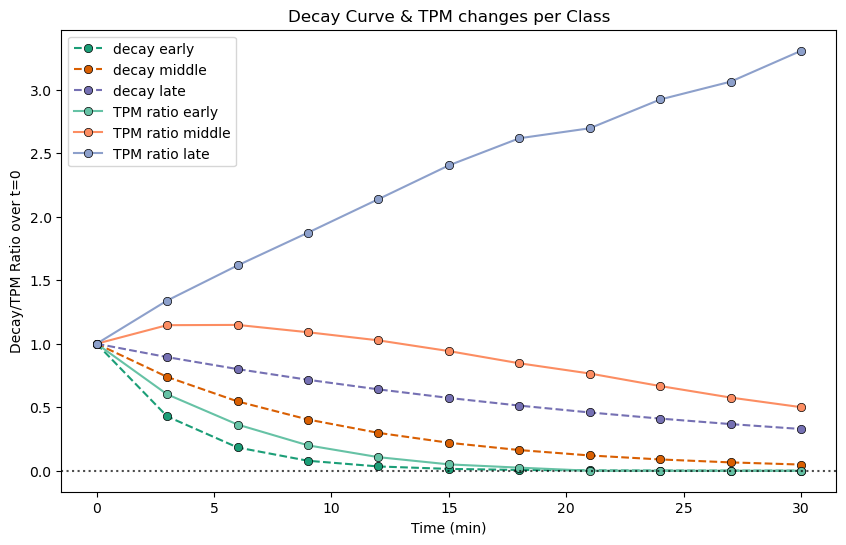

In [25]:
# defining the time points for the plot
timepoints = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30]

# adding a 'decay_0' column with value 1 for all genes in the decay rates data
decay_rates['decay_0'] = 1

# adding a '0_0_ratio' column with value 1 for all genes in the tpm ratios data
TPM_ratios.loc[:, '0_0_ratio'] = 1

# setting the color palette for the classes
decay_class_colors = sns.color_palette("Dark2", n_colors=len(decay_rates['class'].unique()))
TPM_class_colors = sns.color_palette("Set2", n_colors=len(TPM_ratios['class'].unique()))

# creating the figure
fig, ax = plt.subplots(figsize=(10, 6))

# plotting the decay rates (dashed lines)
for i, class_value in enumerate(decay_rates['class'].unique()):
    class_data = decay_rates[decay_rates['class'] == class_value]
    
    # calculating the median decay for each time point
    medians_decay = [1] + [class_data[f'decay_{t}'].median() for t in timepoints[1:]]  # starts at 1 for t=0
    
    # plotting the median decays
    ax.plot(timepoints, medians_decay, label=f'decay {class_value}',
            marker='o', markeredgecolor='black', markerfacecolor=decay_class_colors[i], markeredgewidth = 0.5,
            linewidth=1.5, linestyle='--', color=decay_class_colors[i])


# plotting the tpm ratio over t=0 (solid lines)
for i, class_value in enumerate(TPM_ratios['class'].unique()):
    class_data = TPM_ratios[TPM_ratios['class'] == class_value]
    
    # calculating the median tpm ratio for each time point
    medians_TPM = [1] + [class_data[f'{t}_0_ratio'].median() for t in timepoints[1:]] # starts at 1 for t=0
    
    # plotting the median TPMs
    ax.plot(timepoints, medians_TPM, label=f'TPM ratio {class_value}',
            marker='o', markeredgecolor='black', markerfacecolor=TPM_class_colors[i], markeredgewidth = 0.5,
            linewidth=1.5, linestyle='-', color=TPM_class_colors[i])

# adding a dashed black line at y = 0
ax.axhline(y=0, color='black', linestyle='dotted', linewidth=1.5, alpha=0.7)

# setting labels and title
ax.set_xlabel('Time (min)')
ax.set_ylabel('Decay/TPM Ratio over t=0')
ax.set_title('Decay Curve & TPM changes per Class')

# adding a legend
ax.legend()

# displaying the plot
plt.show()

In this plot, the estimated decay of each gene class follows the exponential curve dictated by the formula, with changes in the decay rates betwen classes. As expected, early genes decay quickly, followed by middle genes, while late genes decay the slowest. 

The TPM ratios over time follow the trends observed in Moriarity's analysis, and can be better understood by looking at the estimated decay curves: **TPM values of early genes closely follow the estimated decay curve and decrease rapidly**. **Middle genes show a slight increase in TPM compared to t=0 at earlier time points (3–12 minutes), due to the rapid decay of early genes**. **At later time points, middle genes begin to decay more significantly (corresponding to their halflife time), and their TPMs start to decrease**. **Late gene TPMs continue to increase throughout the experiment because both early and middle genes decay before them, which increases their relative proportion in the sample.**

In [26]:
import watermark
%load_ext watermark
%watermark -v -m -p numpy,matplotlib,seaborn,pandas,jupyterlab

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

numpy     : 2.1.1
matplotlib: 3.9.2
seaborn   : 0.13.2
pandas    : 2.2.2
jupyterlab: 4.2.5

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 22.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 12
Architecture: 64bit

